# This is a notebook about predicting aurora

# 0. Data Downloading

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
import calendar
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, seasonal_plot, month_plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "figure.figsize": (7,5), "lines.linewidth": 2})

In [4]:
# Downloading Kp Index data from https://www.gfz-potsdam.de/
from getKpindex import getKpindex

kpindex_data = getKpindex(starttime="1932-01-01", endtime=datetime.today().strftime('%Y-%m-%d'), index="Kp")

# 1. Exploratory Data Analysis

## 1.1 Data Exploration
Let's first take a look at the dataset. Clean it if necessary, and try to make sense of the data. 

In [5]:
# Since kpindex_data is a transposed 2D list or array, transpose it back to the correct format.
kpindex_data_transposed = list(zip(*kpindex_data))

# Convert to a DataFrame
kpindex_df = pd.DataFrame(kpindex_data_transposed, columns=["Datetime", "Kp_Index", "Status"])

# Convert 'Datetime' to pandas datetime object
kpindex_df['Datetime'] = pd.to_datetime(kpindex_df['Datetime'])

kpindex_df.head()

,Datetime,Kp_Index,Status
0,1932-01-01 00:00:00+00:00,3.333,def
1,1932-01-01 03:00:00+00:00,2.667,def
2,1932-01-01 06:00:00+00:00,2.333,def
3,1932-01-01 09:00:00+00:00,2.667,def
4,1932-01-01 12:00:00+00:00,3.333,def


In [6]:
# Check for any missing data
kpindex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270872 entries, 0 to 270871
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   Datetime  270872 non-null  datetime64[ns, UTC]
 1   Kp_Index  270872 non-null  float64            
 2   Status    270872 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 6.2+ MB


In [7]:
# Check for missing values
kpindex_df.isnull().sum()

Datetime    0
Kp_Index    0
Status      0
dtype: int64

There is three columns in the downloaded data, corresponding to the datetime of the record, the Kp index at the time, and whether it's a recorded or predicted value. There is no missing data in the datasets, so I won't need to perform any imputation. 

In [8]:
# Let's define a function for plotting the Kp index over a specified date range. 

def plot_kp_index_by_date_range(kpindex_data, start_date=None, end_date=None):
    """
    Function to filter Kp index data by a specific date range, plot the data, and highlight the highest point.
    
    Parameters:
    kpindex_data (pd.DataFrame): The full Kp index dataset containing 'Datetime' and 'Kp_Index'.
    start_date (str, optional): The start date (inclusive) in the format 'YYYY-MM-DD'. Defaults to None, showing all data.
    end_date (str, optional): The end date (exclusive) in the format 'YYYY-MM-DD'. Defaults to None, showing all data.
    
    Returns:
    None
    """

    # Ensure 'Datetime' is in datetime format
    kpindex_data['Datetime'] = pd.to_datetime(kpindex_data['Datetime'])
    
    # Filter the data for the given date range
    if start_date and end_date:
        filtered_data = kpindex_data[(kpindex_data['Datetime'] >= start_date) & 
                                     (kpindex_data['Datetime'] < end_date)]
    else:
        filtered_data = kpindex_data

    # Check if data exists in the date range
    if filtered_data.empty:
        print("No data available for the specified date range.")
        return
    
    # Find the highest Kp index value and its corresponding time
    peak_kp_value = filtered_data['Kp_Index'].max()
    peak_kp_time = filtered_data[filtered_data['Kp_Index'] == peak_kp_value]['Datetime'].values[0]
    
    # Plot the filtered data
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_data['Datetime'], filtered_data['Kp_Index'], label="Kp Index", color='blue')

    # Highlight the peak
    plt.scatter(peak_kp_time, peak_kp_value, color='red', zorder=5, label=f'Peak Kp Index ({pd.to_datetime(peak_kp_time).strftime("%Y-%m-%d")} UTC)')

    # Annotate the peak value
    plt.text(peak_kp_time, peak_kp_value + 0.2, f"Peak: {peak_kp_value:.1f}", color='red')

    # Labels and title
    if start_date and end_date:
        title = f'Kp Index from {start_date} to {end_date} (Highlighted Peak)'
    else:
        title = 'Kp Index (Highlighted Peak for All Data)'
    
    plt.xlabel('Date')
    plt.ylabel('Kp Index')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()


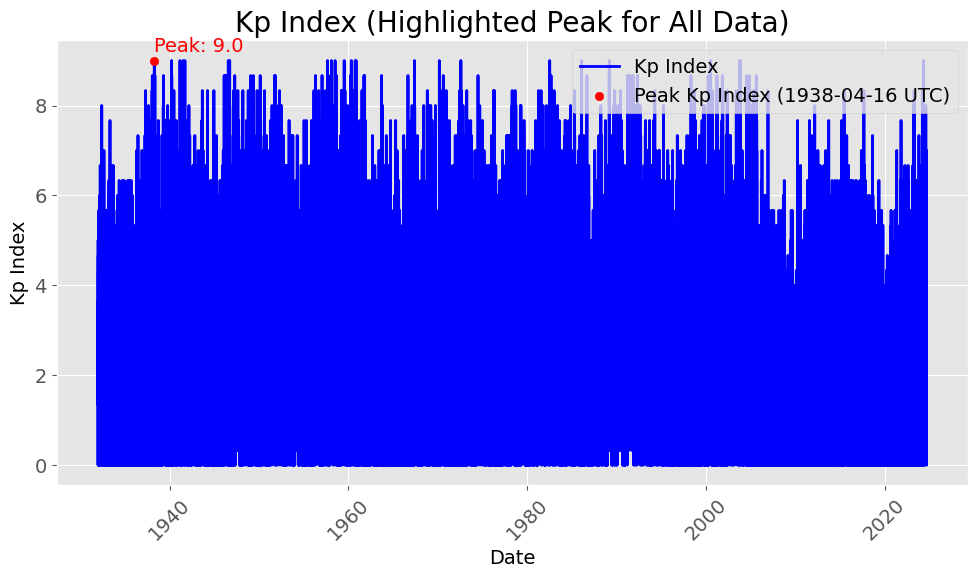

In [9]:
# To show all data:
plot_kp_index_by_date_range(kpindex_df)

This is a very large plot with many years of data. There doesn't seem to be an increase or decrease in Kp index over the long timeframe, as suggested by the flat trend. 

Let's look at the peak Kp index for every year since 1932. 

<Axes: title={'center': 'Annual Peak in Kp Index'}, xlabel='Year', ylabel='Kp Index)'>

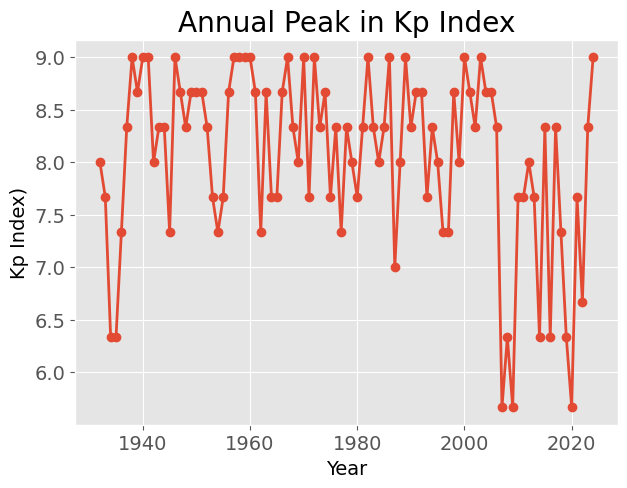

In [10]:
annual_peak = kpindex_df["Kp_Index"].groupby(kpindex_df['Datetime'].dt.year).max()

annual_peak.plot.line(xlabel="Year", ylabel="Kp Index)", title="Annual Peak in Kp Index", marker="o")

As I intended to forecast aurora presence per day, I'm going to take the 24 hours mean. 

In [11]:
# Create a new column for the date only (ignore the time part)
kpindex_df['Date'] = kpindex_df['Datetime'].dt.date

# Group by the 'Date' column and calculate the mean Kp index per day
daily_mean_df = kpindex_df.groupby('Date').agg(Daily_Kp_Max=('Kp_Index', 'max')).reset_index()

daily_mean_df = pd.DataFrame(daily_mean_df)

daily_mean_df = daily_mean_df.rename(columns={"Date": "Datetime", "Daily_Kp_Max": "Kp_Index"})

daily_mean_df.head()

,Datetime,Kp_Index
0,1932-01-01,3.333
1,1932-01-02,5.000
2,1932-01-03,3.333
3,1932-01-04,2.000
4,1932-01-05,2.000


Let's plot all data again. Hopefully this is clearer. 

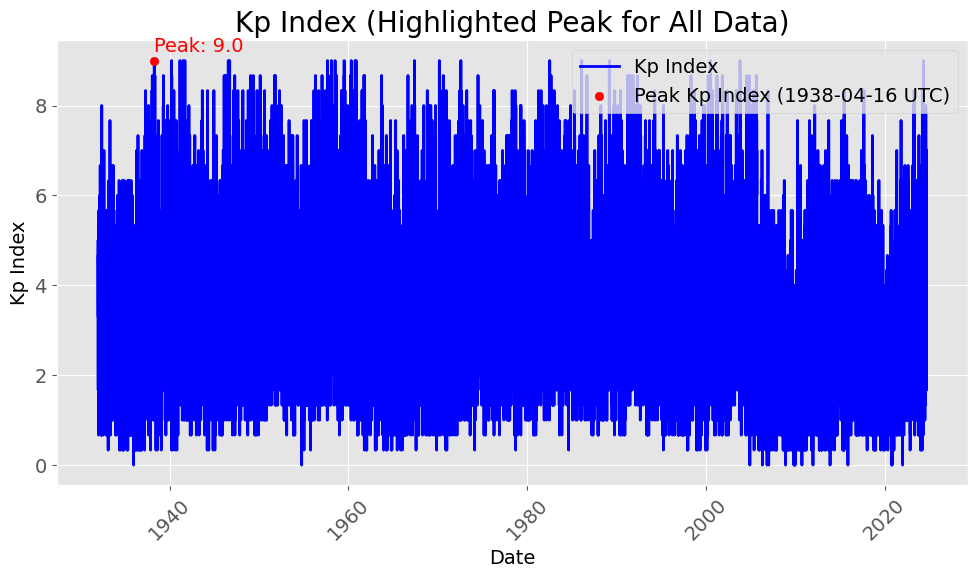

In [12]:
# To show all data:
plot_kp_index_by_date_range(daily_mean_df)

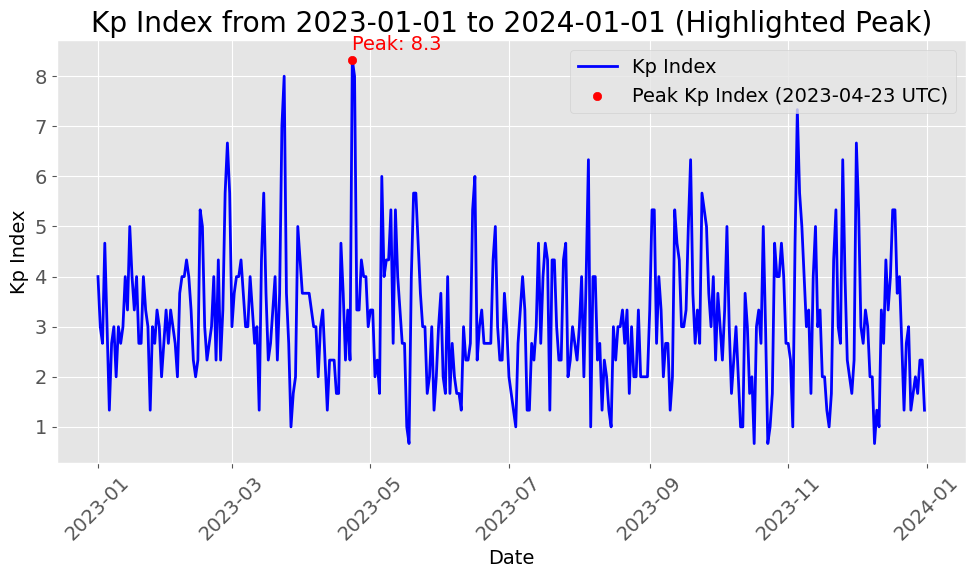

In [13]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_mean_df, '2023-01-01', '2024-01-01')

There are ups and downs in the Kp Index but overall there isn't a upward or downward trend. 

Let's look at the past month only (August 2024). 

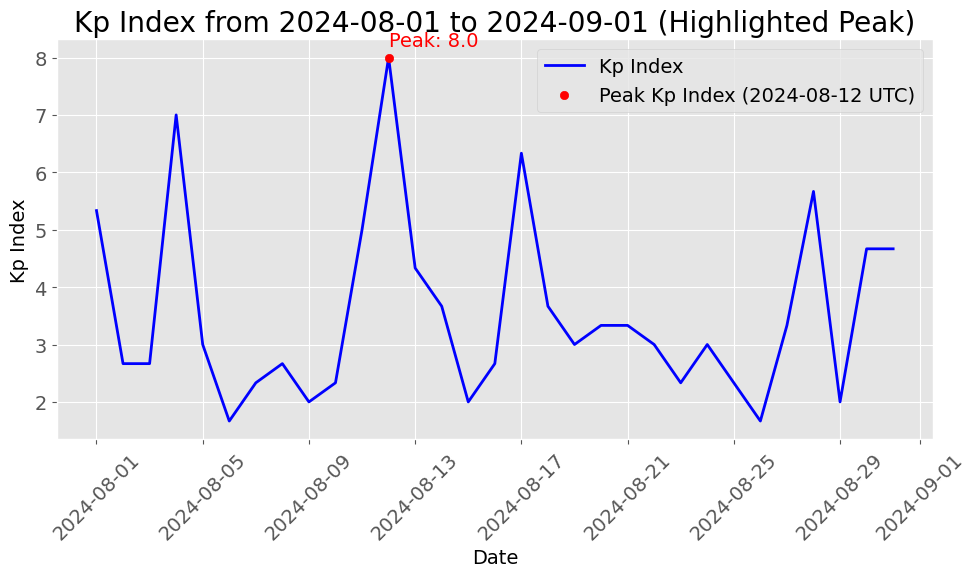

In [14]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_mean_df, '2024-08-01', '2024-09-01')

Looks like there are variations of different widths. I personally was able to see aurora borealis on August 12th, 2024, which had the peak in Kp index. 

I saw another one in May 2024. Let's see if we can find it using the plot.

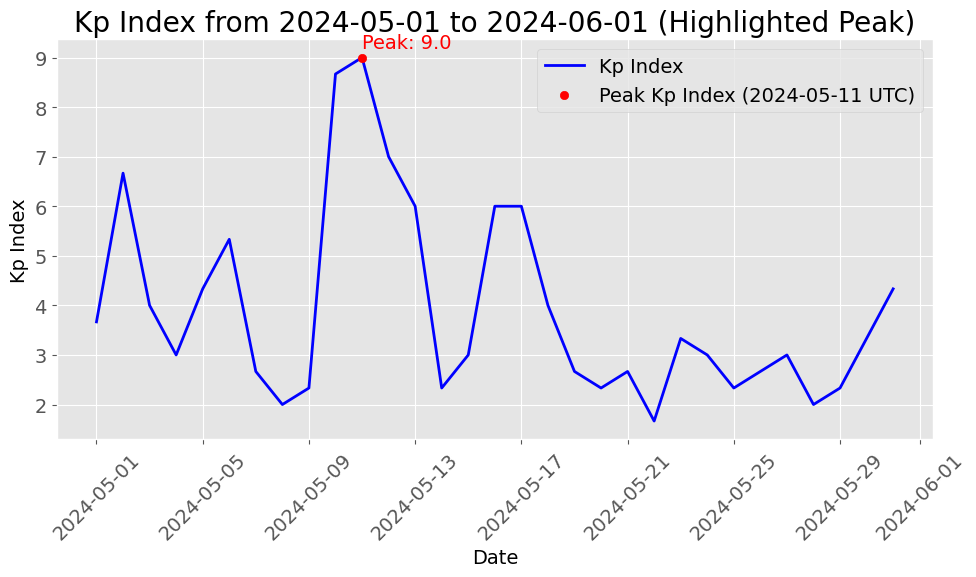

In [15]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_mean_df, '2024-05-01', '2024-06-01')

What about in September 2024?

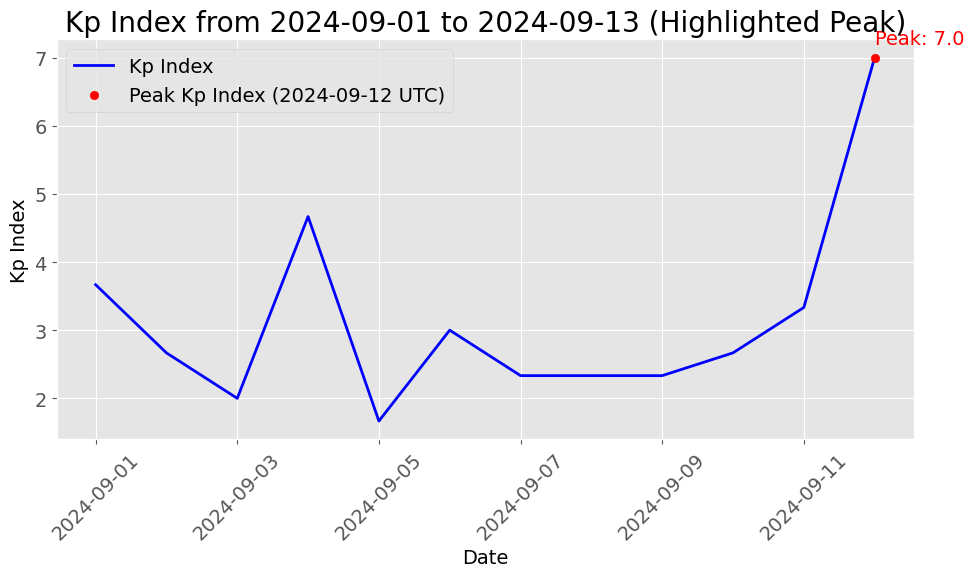

In [16]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_mean_df, '2024-09-01', '2024-09-13')

## 1.2 Autocorrelation (Trends)
With a lot of time-series data, there are temporal dependence, which means the value at a time is dependent on the value in the past. I will now take a look at this dependence, which is also called "autocorrelation". 

Firstly, let's examine if there are trends over the years. I'm going to try the polynomila orders 0, 1, and 3 to capture the trend.

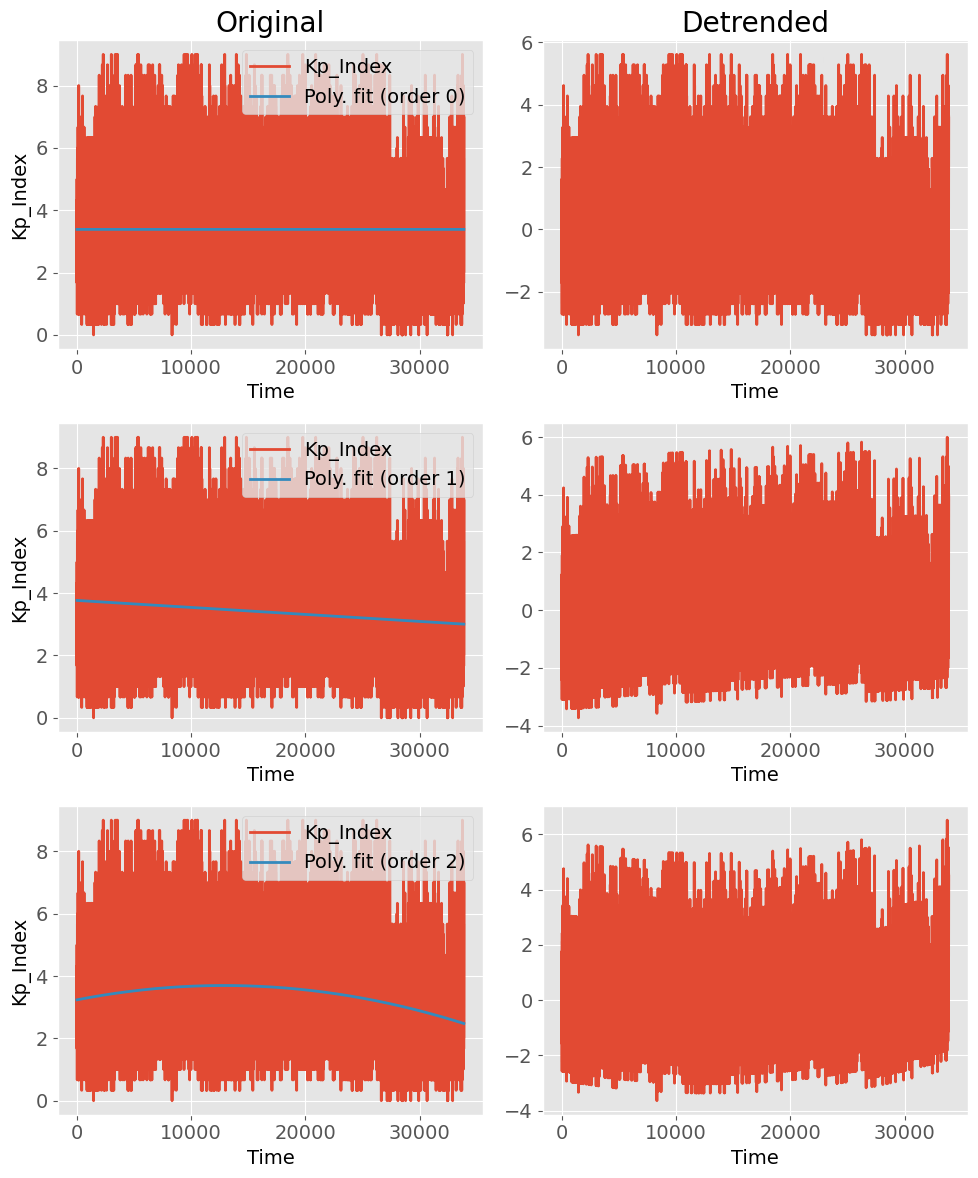

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

for order in range(3):
    fit_label = f"Poly. fit (order {order})"
    daily_mean_df[fit_label] = daily_mean_df["Kp_Index"] - detrend(daily_mean_df["Kp_Index"], order=order)
    daily_mean_df[["Kp_Index", fit_label]].plot.line(xlabel="Time", ylabel="Kp_Index", ax=axes[order, 0])
    (daily_mean_df["Kp_Index"] - daily_mean_df[fit_label]).plot.line(xlabel="Time", legend=False, ax=axes[order, 1])
axes[0, 0].set_title("Original")
axes[0, 1].set_title("Detrended")
plt.tight_layout();

Looks like the polynomial fit of order 0 had the better looking detrended data. I guess the data over the entire period of time isn't increaseing or decreasing. The lines seem to converge around Kp_Index of 3.385088, as indicated in the Poly. fit (order 0). We can use detrending to remove this. 

In [18]:
daily_mean_df['detrended'] = daily_mean_df["Kp_Index"] - daily_mean_df['Poly. fit (order 0)']
daily_mean_df.head()

,Datetime,Kp_Index,Poly. fit (order 0),Poly. fit (order 1),Poly. fit (order 2),detrended
0,1932-01-01,3.333,3.385176,3.765092,3.236318,-0.052176
1,1932-01-02,5.000,3.385176,3.765069,3.236390,1.614824
2,1932-01-03,3.333,3.385176,3.765047,3.236461,-0.052176
3,1932-01-04,2.000,3.385176,3.765024,3.236532,-1.385176
4,1932-01-05,2.000,3.385176,3.765002,3.236603,-1.385176


In [19]:
# import seaborn as sns
# daily_mean_df['Day_of_Year'] = daily_mean_df['Datetime'].dt.dayofyear
# plt.figure(figsize=(20, 6))
# sns.lineplot(daily_mean_df, x=daily_mean_df['Datetime'].dt.dayofyear, y='Kp_Index', hue=daily_mean_df['Datetime'].dt.year, alpha  = 0.1,palette=['blue'],legend=False)

In [20]:
# plt.figure(figsize=(20, 6))
# sns.lineplot(daily_mean_df, x=daily_mean_df['Datetime'].dt.dayofyear, y='detrended', hue=daily_mean_df['Datetime'].dt.year, alpha  = 0.1,palette=['blue'],legend=False)

Now after subtracting all daily values by 3.385088, the lines seem to converge around 0. 

## 1.3 Seasonality

Let's do some exploration first. I'm curious to see how the Kp index repeat over days in a month, and months in a year and .

In [21]:
seasonal = daily_mean_df["detrended"].groupby(daily_mean_df['Datetime'].dt.day).mean()
seasonal.head()

Datetime
1    0.104488
2    0.073036
3    0.002966
4    0.058072
5   -0.033592
Name: detrended, dtype: float64

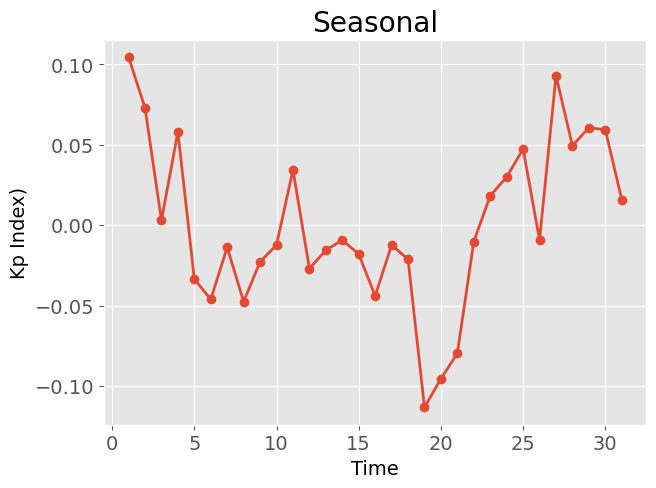

In [22]:
ax = seasonal.plot.line(xlabel="Time", ylabel="Kp Index)", title="Seasonal", marker="o")

In [23]:
seasonal = daily_mean_df["detrended"].groupby(daily_mean_df['Datetime'].dt.month).mean()
seasonal

Datetime
1    -0.147105
2     0.088192
3     0.303690
4     0.253537
5    -0.028954
6    -0.204896
7    -0.192895
8    -0.054392
9     0.243007
10    0.150594
11   -0.098709
12   -0.299151
Name: detrended, dtype: float64

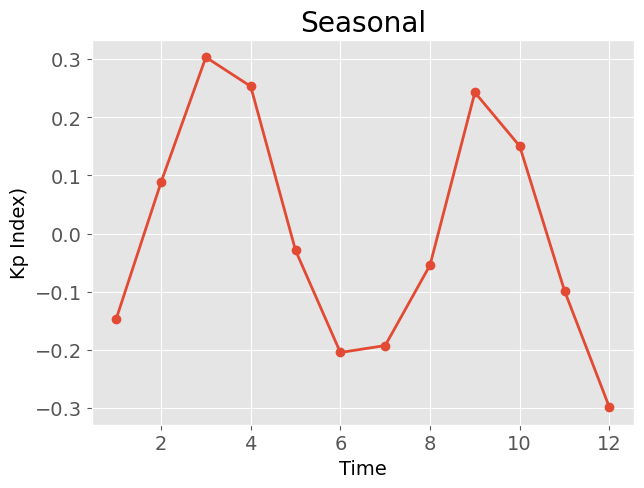

In [24]:
ax = seasonal.plot.line(xlabel="Time", ylabel="Kp Index)", title="Seasonal", marker="o")

We can see that over a year, the Kp index tends to peak during March and September. 

Let's save the seasonal pattern as a column in our df. 

In [25]:
daily_mean_df["seasonal"] = daily_mean_df['Datetime'].dt.month.map(lambda x: seasonal.to_dict()[x])
daily_mean_df.head()

,Datetime,Kp_Index,Poly. fit (order 0),Poly. fit (order 1),Poly. fit (order 2),detrended,seasonal
0,1932-01-01,3.333,3.385176,3.765092,3.236318,-0.052176,-0.147105
1,1932-01-02,5.000,3.385176,3.765069,3.236390,1.614824,-0.147105
2,1932-01-03,3.333,3.385176,3.765047,3.236461,-0.052176,-0.147105
3,1932-01-04,2.000,3.385176,3.765024,3.236532,-1.385176,-0.147105
4,1932-01-05,2.000,3.385176,3.765002,3.236603,-1.385176,-0.147105


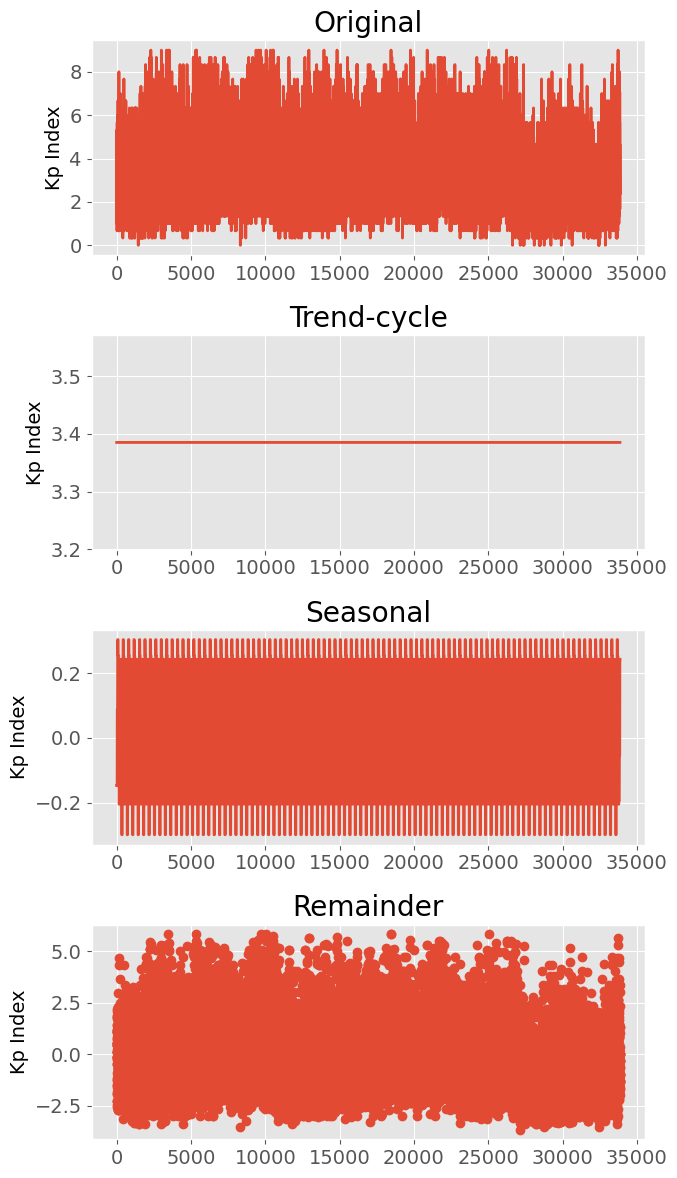

In [26]:
# Estimating the remainder
daily_mean_df["remainder"] = daily_mean_df["Kp_Index"] - daily_mean_df["Poly. fit (order 0)"] - daily_mean_df["seasonal"]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7, 12))
daily_mean_df["Kp_Index"].plot.line(ylabel="Kp Index", title="Original", xlabel="", ax=axes[0])
daily_mean_df["Poly. fit (order 0)"].plot.line(ylabel="Kp Index", title="Trend-cycle", xlabel="", ax=axes[1])
daily_mean_df["seasonal"].plot.line(ylabel="Kp Index", title="Seasonal", xlabel="", ax=axes[2])
daily_mean_df["remainder"].plot.line(ylabel="Kp Index", title="Remainder", ax=axes[3], marker="o", linestyle="")
plt.tight_layout();

Text(0, 0.5, 'ACF')

<Figure size 2000x600 with 0 Axes>

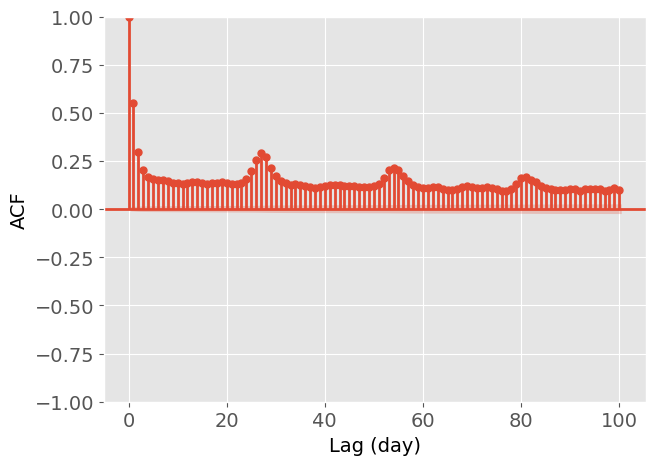

In [27]:
plt.figure(figsize=(20, 6))
plot_acf(daily_mean_df["Kp_Index"], lags=100, title=None, bartlett_confint=True)
plt.xlabel("Lag (day)")
plt.ylabel('ACF')

Text(0, 0.5, 'PACF')

<Figure size 2000x600 with 0 Axes>

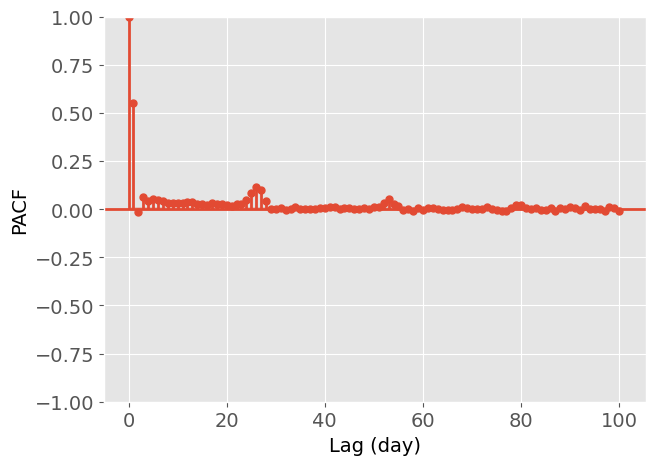

In [28]:
plt.figure(figsize=(20, 6))
plot_pacf(daily_mean_df["Kp_Index"], lags=100, title=None)
plt.xlabel("Lag (day)")
plt.ylabel('PACF')

There seems to be a cycle of autocorrelation around every 25-30 lags. Maybe this is the cycle of the sun (the Sun rotates on its axis once in 27 days)? 

Also, as the ACF value drops rapidly after lag 3, there isn't really an obvious trend to observe, as we hypothesized earlier.

Let me first get the exact lag value. 

In [29]:
acf_data = acf(daily_mean_df["Kp_Index"], nlags=100, bartlett_confint=True)
acf_data[:25]

array([1.        , 0.55375371, 0.29628481, 0.20322862, 0.16504648,
       0.15639513, 0.15293998, 0.15098648, 0.14415189, 0.13804213,
       0.13416126, 0.13295277, 0.1371472 , 0.14354244, 0.14039805,
       0.13617299, 0.13181917, 0.13530603, 0.13836272, 0.13912438,
       0.13704007, 0.13036135, 0.13128053, 0.13687319, 0.15553921])

In [30]:
# Create lags array
lags = np.arange(len(acf_data))

# Define the range for finding the highest point
start_lag = 20
end_lag = 40

# Find indices within the specified lag range
indices_within_range = np.where((lags >= start_lag) & (lags <= end_lag))[0]

# Find the maximum ACF value within this range
max_index = indices_within_range[np.argmax(acf_data[indices_within_range])]
max_lag = lags[max_index]
max_acf_value = acf_data[max_index]

print(f'The maximum ACF value is at lag {max_lag} with a value of {max_acf_value}.')

The maximum ACF value is at lag 27 with a value of 0.2912071912714566.


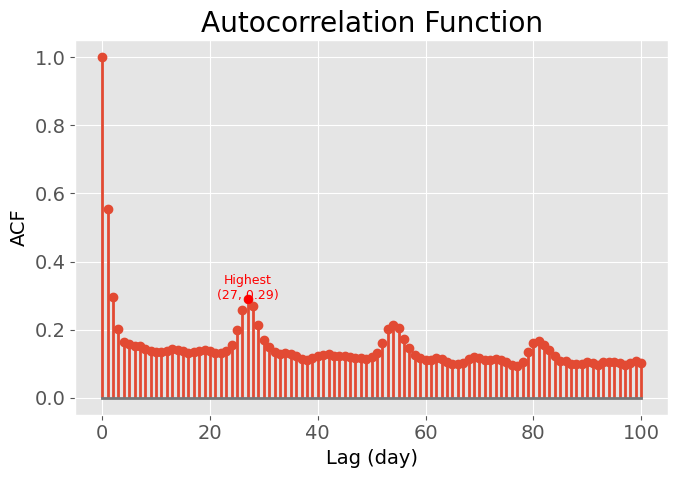

In [31]:
# Plot ACF
plt.stem(lags, acf_data, use_line_collection=True)
plt.xlabel("Lag (day)")
plt.ylabel('ACF')

# Annotate the highest point
plt.scatter(max_lag, max_acf_value, color='red', zorder=5)
plt.text(max_lag, max_acf_value, f'Highest\n({max_lag}, {max_acf_value:.2f})',
         color='red', fontsize=9, ha='center')

plt.title('Autocorrelation Function')
plt.tight_layout()
plt.show()

Let's explore how the Kp index repeats every 27 days.

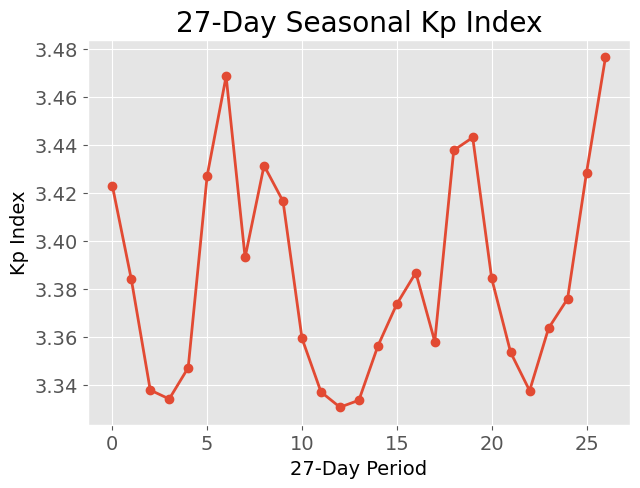

In [32]:
# Create a 27-day period identifier based on the day of the dataset
daily_mean_df['27_Day_Group'] = daily_mean_df.index % 27  # Grouping every 27 days

# Calculate the mean for each 27-day group across all years
seasonal = daily_mean_df.groupby('27_Day_Group')['Kp_Index'].mean()

# Plot the seasonal pattern
ax = seasonal.plot.line(xlabel="27-Day Period", ylabel="Kp Index", 
                        title="27-Day Seasonal Kp Index", marker="o")


We can see that there are some variations of average Kp index in the 27 day period. However, keep in mind of the scale of changes, which is only from 3.34 to 3.48. The variation is not too big. 

There is also the solar cycle, which lasts for 11 years. Let's explore that

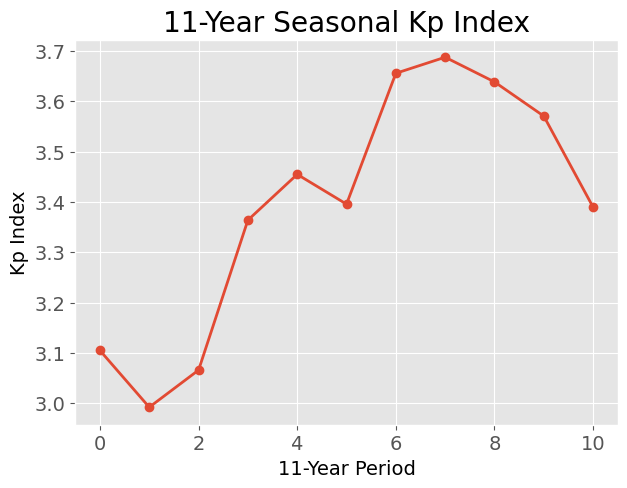

In [33]:
# Extract the year from 'Datetime'
daily_mean_df['Year'] = daily_mean_df['Datetime'].dt.year

# Create an 11-year period identifier based on the year. As the first conventionally stated solar cycle began in 1755. We subtract 1755 from each year to indicate which year is it at during a cycle. 
daily_mean_df['11_Year_Group'] = (daily_mean_df['Year'] - 1755) % 11

# Calculate the mean for each 11-year group across all years
seasonal = daily_mean_df.groupby('11_Year_Group')['Kp_Index'].mean()

# Plot the seasonal pattern
ax = seasonal.plot.line(xlabel="11-Year Period", ylabel="Kp Index", 
                        title="11-Year Seasonal Kp Index", marker="o")

We can see that the average variation in Kp Index for 11 year period is larger, ranging from 3.0 to 3.7, as compared to the changes in the 27 day period above. 

So there seems to be the autocorrelation at 27 days. 

Let's use `STL` to remove this seasonality. This is a more advanced method of decomposition which uses LOESS (locally estimated scatterplot smoothing).

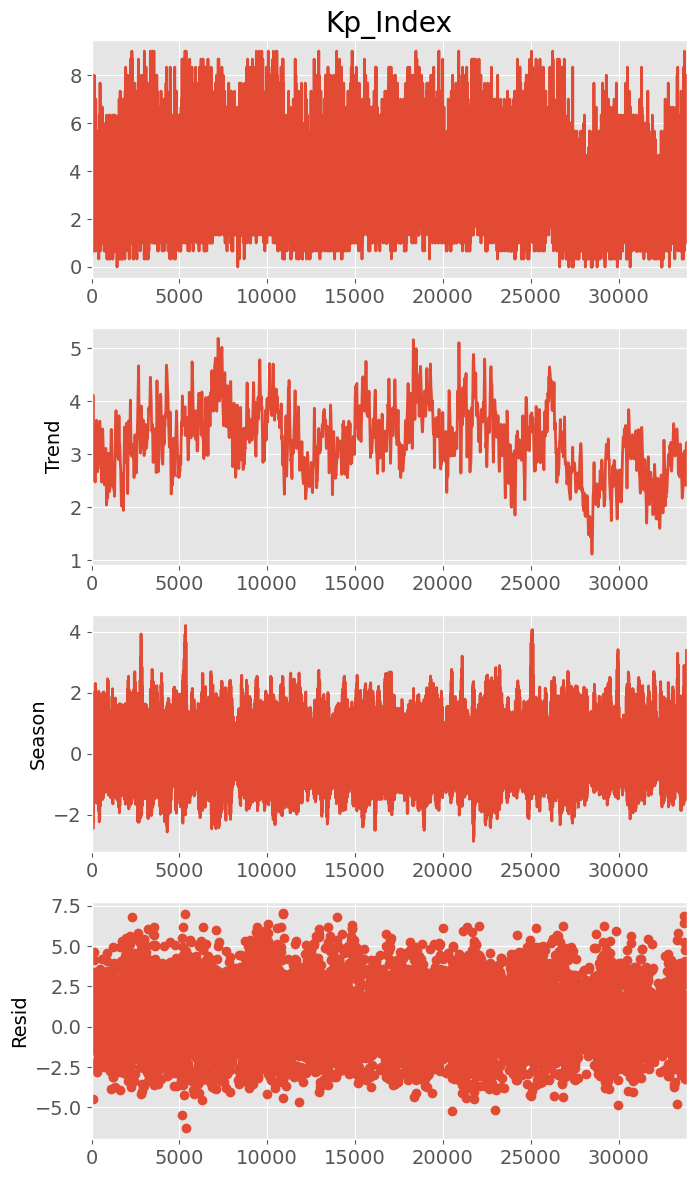

In [34]:
from statsmodels.tsa.seasonal import STL
model = STL(daily_mean_df["Kp_Index"], period=27, trend=55, robust=True).fit()
with mpl.rc_context():
    mpl.rc("figure", figsize=(7, 12))
    model.plot()

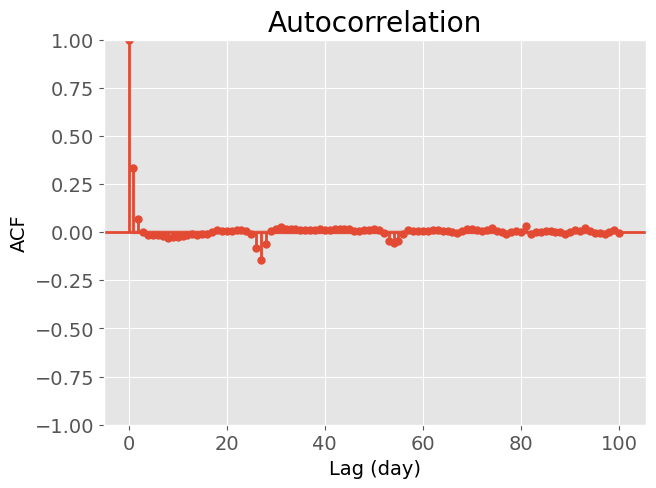

In [35]:
fig = plot_acf(model.resid, lags=100)
plt.ylabel("ACF")
plt.xlabel("Lag (day)");

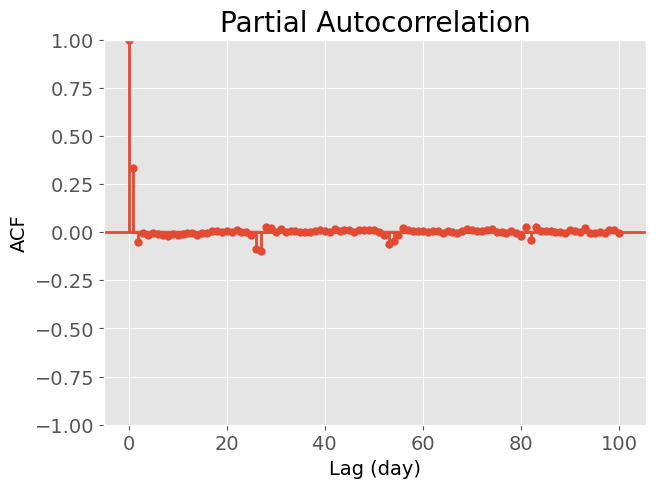

In [36]:
fig = plot_pacf(model.resid, lags=100)
plt.ylabel("ACF")
plt.xlabel("Lag (day)");

The detrended data looks much better. There seems to be still autocorrelation at the lag 1, which we can take care of in modelling. Also, although there are still some negatively correlated data points around lag 27, but it's pretty good already. 

Text(0.5, 1.0, 'Rolling std')

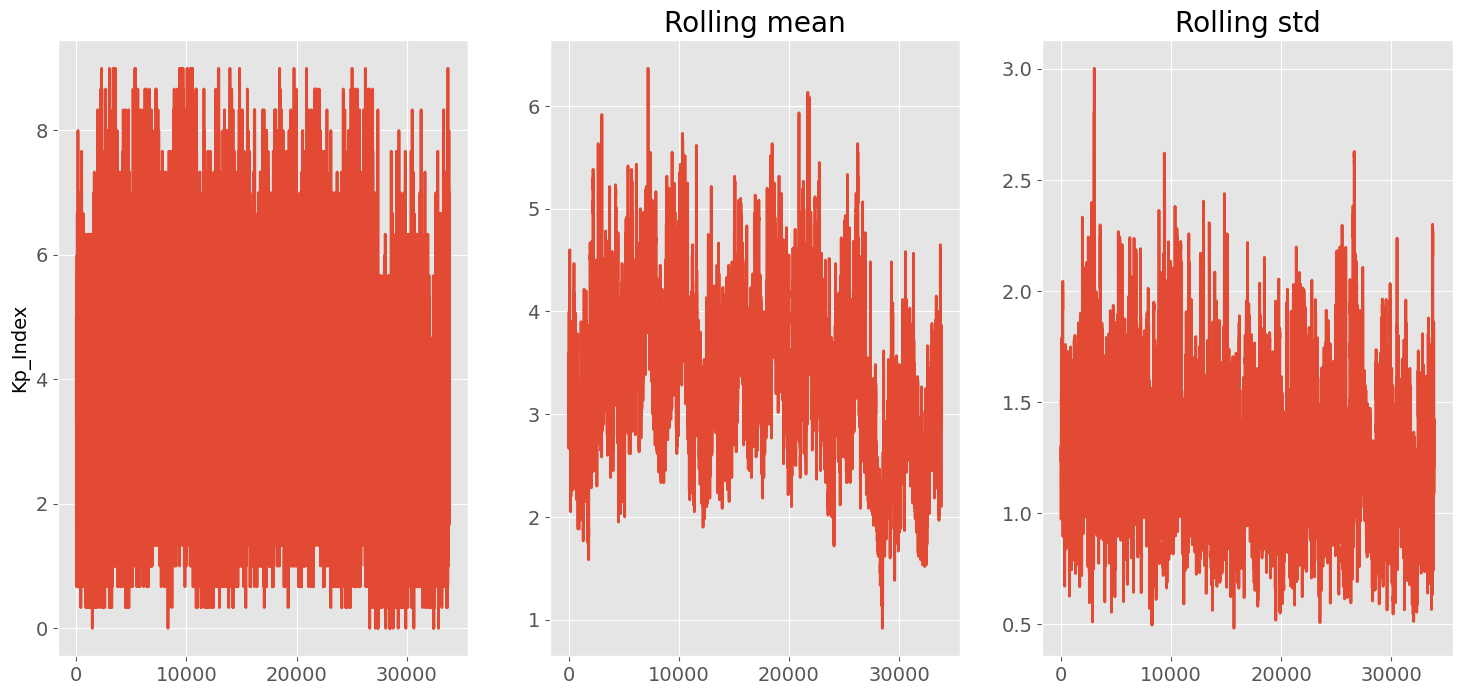

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
wd_size = 20

daily_mean_df['Kp_Index'].plot(ax=axes[0])
axes[0].set(ylabel='Kp_Index')
daily_mean_df['Kp_Index'].rolling(wd_size, min_periods=5).mean().plot(ax=axes[1])
axes[1].set_title('Rolling mean')
daily_mean_df['Kp_Index'].rolling(wd_size, min_periods=5).std().plot(ax=axes[2])
axes[2].set_title('Rolling std')

In [38]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(daily_mean_df['Kp_Index'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.709645
p-value: 0.000000


Using ADF (Augmented Dickey Fuller) test, we have evidence to reject the null hypothesis, which hypothesizes that the time-series is non-stationary.

My typical approach is as follows

- Naive (seasonally-adjusted if necessary) / Seasonal naive
- ETS (for SES, or Holt, seasonally-adjust if necessary)
- ARIMA
- ML (next lecture)
- Combinations of the above

# 2. Modelling

## 2.1 Train-Test Split

Before building our model, we need to split the data into a training set (for model training) and a test set (to evaluate model performance). As for time-series, this has special consideration as 1) we do not shuffle the data to preserve the temporal component and 2) we use a sliding window approach as we have an abundance of data points. 

Training data length: 33494
Test data length: 365


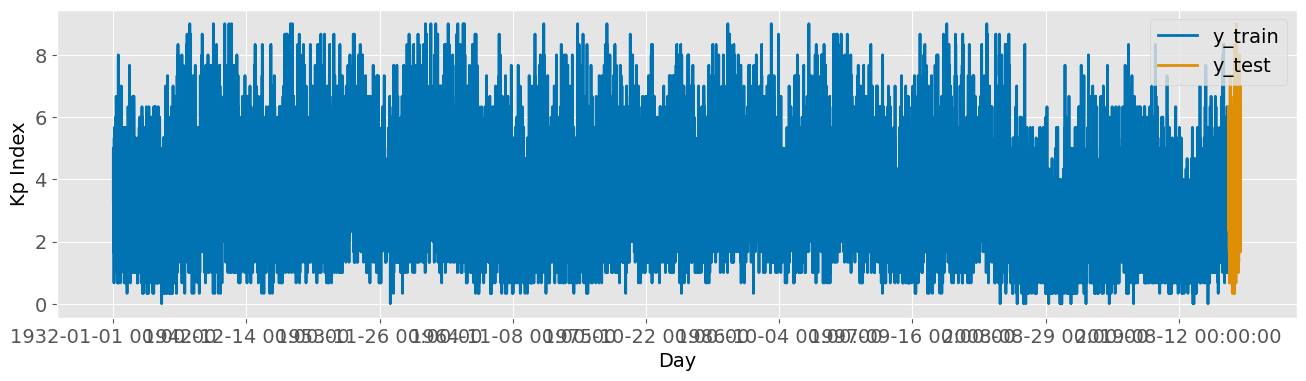

In [48]:
from sktime.forecasting.model_selection import  SlidingWindowSplitter, temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon

y = daily_mean_df[['Datetime', 'Kp_Index']].set_index('Datetime')

y_train, y_test = temporal_train_test_split(y, test_size = 365)
fig, ax = plot_series(y_train, y_test, labels=["y_train", "y_test"],x_label="Day", y_label="Kp Index", markers=[',',','],)

# Verify the split
print(f"Training data length: {len(y_train)}")
print(f"Test data length: {len(y_test)}")

So in this split, the most recent 1 year (365 days) are used as the test set. Based on the result goes, I may need to adjust this value. 

We now need to define a validation set to help us optimize the model. Remember, the golden rule of machine learning is that the algorithm/model should not see the test set until the very last step to report score. 

In [50]:
# Specify forecast horizon. This has the same length minus one as the test set.
fh = ForecastingHorizon(np.arange(1,len(y_test)))
len(fh)

364

In [57]:
cv = SlidingWindowSplitter(window_length=4015, step_length=365, fh=fh)

n_splits = cv.get_n_splits(y_train)
print(f"Number of Folds = {n_splits}")

Number of Folds = 80


In [58]:
from warnings import simplefilter
import seaborn as sns
from matplotlib.ticker import MaxNLocator

def plot_windows(y, train_windows, test_windows, title=""):
    """Visualize training and test windows"""

    simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Train",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Validation",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
    ax.legend(handles, labels);
    
def get_windows(y, cv):
    """Generate windows"""
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows



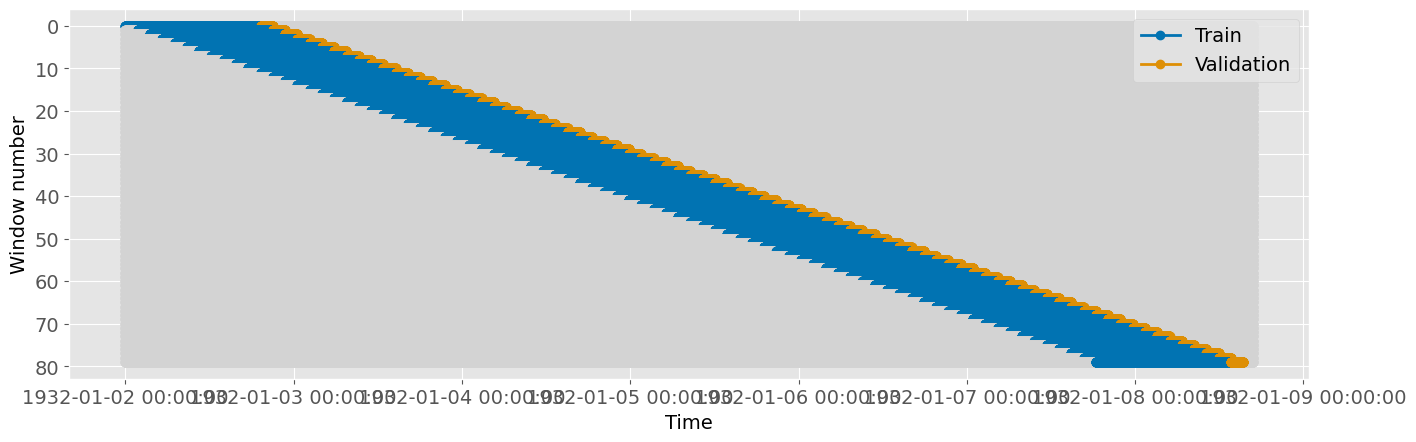

In [61]:
train_windows, test_windows = get_windows(y_train, cv)

plot_windows(y_train, train_windows, test_windows)

To explain how the sliding window works, `window = 4015` indicates that I am using every past 11 years's data to predict the 12th year. The `step_length` indicates that I always skip a year before remaking another prediction. This makes some logical sense as in the EDA section, I showed that in every solar cycle, 11 years, the Kp index repeats. 

## 2.2 Fitting a model

## Baseline models: Naive and Auto-ARIMA
Let's start with a simple baseline model using AutoARIMA.

In [68]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA

import pmdarima as pm

results = pm.auto_arima(y_train, start_q=0,start_d=1,start_p=0,
                            max_q=5, max_d=2, max_p=5)
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                33494
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -54081.029
Date:                Thu, 12 Sep 2024   AIC                         108170.058
Time:                        23:39:16   BIC                         108203.734
Sample:                    01-01-1932   HQIC                        108180.807
                         - 09-13-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3683      0.010     35.941      0.000       0.348       0.388
ma.L1         -0.8430      0.011    -76.866      0.000      -0.865      -0.822
ma.L2         -0.1411      0.011    -13.277      0.0

In [69]:
# forecaster = AutoARIMA(sp=27)
# results = evaluate(forecaster=forecaster, y=y_train, cv=cv, strategy="refit", return_data=True)
# results